Loading JSON file: C:\Users\prana\Downloads\padded_bboxes_output.json
Loading image file: C:\Users\prana\Downloads\page (3).png
Processing page...
Creating visualization...


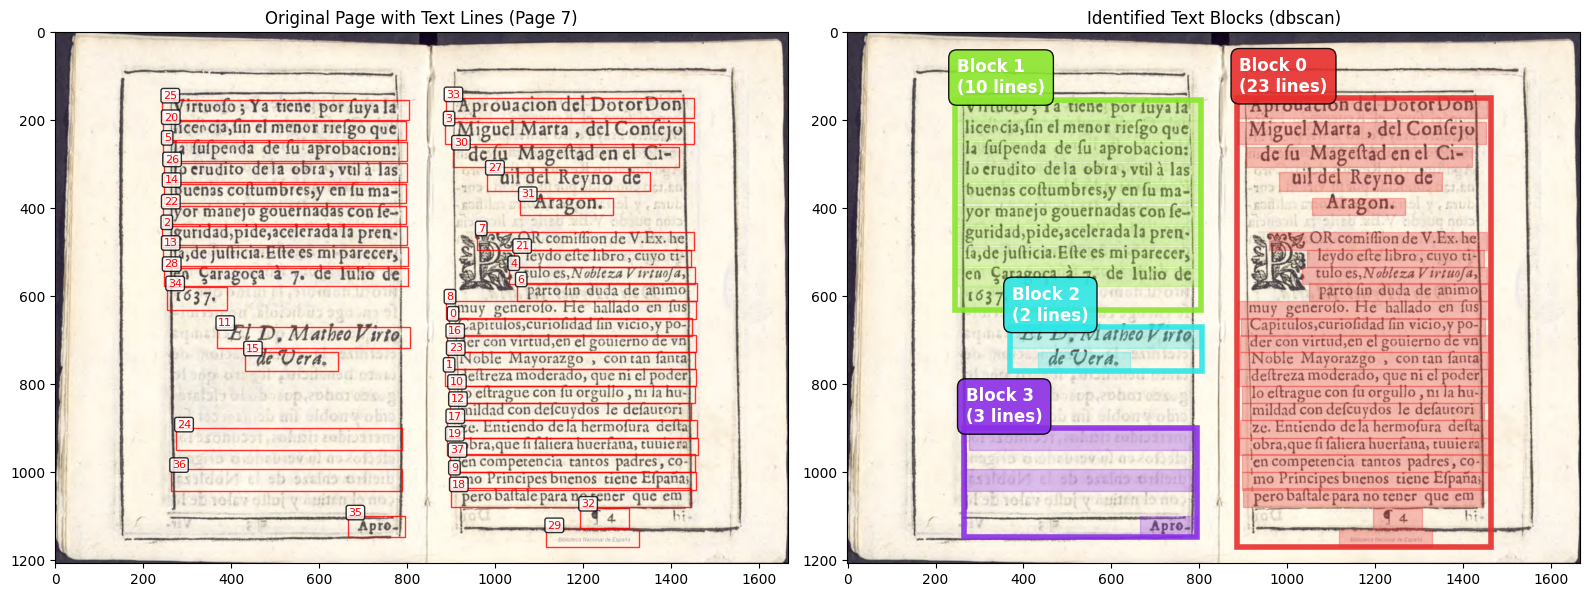


DETAILED CLUSTERING RESULTS
Page Number: 7
Total Text Lines: 38
Number of Blocks Identified: 4
Clustering Method Used: DBSCAN

------------------------------------------------------------
BLOCK DETAILS:
------------------------------------------------------------

📦 BLOCK 0:
   └─ Number of lines: 23
   └─ Bounding box: [886.0, 150.0, 1462.0, 1171.0]
   └─ Dimensions: 576.0 x 1021.0
   └─ Individual lines:
      • Line 1: [895.0, 649.0, 1449.0, 690.0]
      • Line 2: [886.0, 765.0, 1458.0, 805.0]
      • Line 3: [886.0, 205.0, 1452.0, 253.0]
      • Line 4: [1033.0, 534.0, 1455.0, 572.0]
      • Line 5: [1050.0, 571.0, 1459.0, 611.0]
      • Line 6: [959.0, 455.0, 1454.0, 495.0]
      • Line 7: [888.0, 610.0, 1458.0, 651.0]
      • Line 8: [898.0, 999.0, 1458.0, 1040.0]
      • Line 9: [896.0, 804.0, 1456.0, 843.0]
      • Line 10: [898.0, 843.0, 1447.0, 881.0]
      • Line 11: [892.0, 688.0, 1458.0, 728.0]
      • Line 12: [892.0, 882.0, 1459.0, 922.0]
      • Line 13: [900.0, 1037.0

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
import colorsys
from PIL import Image
import os

class TextBlockClusterer:
    def __init__(self, overlap_threshold=0.5, eps=50, min_samples=1):
        """
        Initialize the text block clusterer.
        
        Args:
            overlap_threshold: Minimum horizontal overlap ratio to consider lines related
            eps: DBSCAN epsilon parameter (maximum distance between samples)
            min_samples: DBSCAN minimum samples parameter
        """
        self.overlap_threshold = overlap_threshold
        self.eps = eps
        self.min_samples = min_samples
    
    def load_json(self, json_path):
        """Load bounding boxes from JSON file."""
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data
    
    def load_image(self, image_path):
        """Load and return image."""
        if os.path.exists(image_path):
            return Image.open(image_path)
        else:
            print(f"Warning: Image file {image_path} not found")
            return None
    
    def normalize_bboxes(self, bboxes):
        """
        Convert bounding boxes to normalized representation.
        
        Args:
            bboxes: List of [x1, y1, x2, y2] coordinates
            
        Returns:
            dict with normalized data
        """
        normalized = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x_center = (x1 + x2) / 2
            y_center = (y1 + y2) / 2
            width = x2 - x1
            height = y2 - y1
            
            normalized.append({
                'bbox': bbox,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2
            })
        
        return normalized
    
    def calculate_horizontal_overlap(self, line1, line2):
        """Calculate horizontal overlap ratio between two lines."""
        x1_start, x1_end = line1['x1'], line1['x2']
        x2_start, x2_end = line2['x1'], line2['x2']
        
        # Calculate overlap
        overlap_start = max(x1_start, x2_start)
        overlap_end = min(x1_end, x2_end)
        
        if overlap_start >= overlap_end:
            return 0.0
        
        overlap_width = overlap_end - overlap_start
        min_width = min(line1['width'], line2['width'])
        
        return overlap_width / min_width if min_width > 0 else 0.0
    
    def custom_distance(self, line1, line2):
        """
        Custom distance function for text line clustering.
        
        Considers both vertical and horizontal distances, with special handling
        for horizontally overlapping lines.
        """
        # Vertical distance
        vertical_dist = abs(line1['y_center'] - line2['y_center'])
        
        # Horizontal distance
        horizontal_dist = abs(line1['x_center'] - line2['x_center'])
        
        # Calculate horizontal overlap
        overlap_ratio = self.calculate_horizontal_overlap(line1, line2)
        
        # If lines have significant horizontal overlap, they're likely in the same block
        if overlap_ratio > self.overlap_threshold:
            # Reduce effective distance for overlapping lines
            distance = vertical_dist * 0.5  # Emphasize vertical proximity
        else:
            # For non-overlapping lines, consider both horizontal and vertical distance
            distance = np.sqrt(vertical_dist**2 + horizontal_dist**2)
        
        return distance
    
    def cluster_with_dbscan(self, normalized_lines):
        """Cluster text lines using DBSCAN with custom distance metric."""
        if len(normalized_lines) <= 1:
            return [0] * len(normalized_lines)
        
        # Create distance matrix
        n = len(normalized_lines)
        distance_matrix = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i + 1, n):
                dist = self.custom_distance(normalized_lines[i], normalized_lines[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples, metric='precomputed')
        labels = dbscan.fit_predict(distance_matrix)
        
        # Handle noise points (-1 labels) by assigning them to their own clusters
        max_label = max(labels) if len(labels) > 0 and max(labels) >= 0 else -1
        for i, label in enumerate(labels):
            if label == -1:
                max_label += 1
                labels[i] = max_label
        
        return labels
    
    def cluster_with_hierarchical(self, normalized_lines):
        """Fallback: Hierarchical clustering with custom distance."""
        if len(normalized_lines) <= 1:
            return [0] * len(normalized_lines)
        
        # Create condensed distance matrix for hierarchical clustering
        distances = []
        n = len(normalized_lines)
        
        for i in range(n):
            for j in range(i + 1, n):
                dist = self.custom_distance(normalized_lines[i], normalized_lines[j])
                distances.append(dist)
        
        # Perform hierarchical clustering
        linkage_matrix = linkage(distances, method='average')
        
        # Determine number of clusters dynamically
        max_clusters = min(max(1, len(normalized_lines) // 3), 5)
        labels = fcluster(linkage_matrix, max_clusters, criterion='maxclust') - 1
        
        return labels
    
    def fallback_column_detection(self, normalized_lines):
        """
        Fallback method: Detect columns using x-position histogram peaks.
        """
        if len(normalized_lines) <= 1:
            return [0] * len(normalized_lines)
        
        # Get x-centers
        x_centers = [line['x_center'] for line in normalized_lines]
        
        # Simple column detection using k-means-like approach
        x_centers = np.array(x_centers)
        
        # Determine number of columns by analyzing x-position distribution
        x_sorted = np.sort(x_centers)
        gaps = np.diff(x_sorted)
        
        # Find significant gaps (potential column boundaries)
        gap_threshold = np.mean(gaps) + 2 * np.std(gaps) if len(gaps) > 1 else 0
        significant_gaps = gaps > gap_threshold
        
        num_columns = np.sum(significant_gaps) + 1
        num_columns = min(num_columns, 3)  # Limit to 3 columns max
        
        if num_columns == 1:
            return [0] * len(normalized_lines)
        
        # Simple column assignment based on x-position
        x_boundaries = []
        if num_columns > 1:
            x_boundaries = [x_sorted[i] for i, gap in enumerate(significant_gaps) if gap]
        
        labels = []
        for line in normalized_lines:
            x_pos = line['x_center']
            cluster = 0
            for boundary in x_boundaries:
                if x_pos > boundary:
                    cluster += 1
                else:
                    break
            labels.append(cluster)
        
        return labels
    
    def compute_block_bboxes(self, normalized_lines, labels):
        """Compute bounding boxes for each block."""
        blocks = defaultdict(list)
        
        # Group lines by cluster
        for line, label in zip(normalized_lines, labels):
            blocks[label].append(line)
        
        # Compute bounding box for each block
        block_bboxes = []
        for label, lines in blocks.items():
            if not lines:
                continue
            
            x1_min = min(line['x1'] for line in lines)
            y1_min = min(line['y1'] for line in lines)
            x2_max = max(line['x2'] for line in lines)
            y2_max = max(line['y2'] for line in lines)
            
            block_bboxes.append({
                'label': label,
                'bbox': [x1_min, y1_min, x2_max, y2_max],
                'num_lines': len(lines),
                'lines': lines  # Store individual lines for detailed analysis
            })
        
        return block_bboxes
    
    def process_page(self, data, use_fallback=False):
        """
        Process a single page and return block bounding boxes.
        
        Args:
            data: Dictionary with page data
            use_fallback: Whether to use fallback column detection
            
        Returns:
            Dictionary with results
        """
        if 'padded_bboxes' not in data or not data['padded_bboxes']:
            return {
                'page_number': data.get('page_number', 0),
                'block_bboxes': [],
                'num_blocks': 0,
                'clustering_method': 'none'
            }
        
        # Normalize bounding boxes
        normalized_lines = self.normalize_bboxes(data['padded_bboxes'])
        
        # Try different clustering methods
        if use_fallback:
            labels = self.fallback_column_detection(normalized_lines)
            method = 'column_detection'
        else:
            # Try DBSCAN first
            labels = self.cluster_with_dbscan(normalized_lines)
            method = 'dbscan'
            
            # If DBSCAN results in too many single-line clusters, try hierarchical
            unique_labels = len(set(labels))
            labels_list = list(labels)  # Convert to list for count method
            single_line_clusters = sum(1 for label in set(labels) 
                                     if labels_list.count(label) == 1)
            
            if single_line_clusters > unique_labels * 0.7:  # Too many single-line clusters
                labels = self.cluster_with_hierarchical(normalized_lines)
                method = 'hierarchical'
        
        # Compute block bounding boxes
        block_bboxes = self.compute_block_bboxes(normalized_lines, labels)
        
        return {
            'page_number': data.get('page_number', 0),
            'block_bboxes': block_bboxes,
            'num_blocks': len(block_bboxes),
            'clustering_method': method,
            'line_labels': labels
        }
    
    def visualize_results(self, data, results, image=None, figsize=(16, 12), save_path=None):
        """
        Visualize the clustering results with optional background image.
        
        Args:
            data: Original page data
            results: Clustering results
            image: PIL Image object (optional)
            figsize: Figure size
            save_path: Path to save the visualization
        """
        if image is not None:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        else:
            fig, ax2 = plt.subplots(1, 1, figsize=(figsize[0]//2, figsize[1]))
            ax1 = None
        
        # Generate colors for each cluster
        num_blocks = results['num_blocks']
        colors = []
        for i in range(num_blocks):
            hue = i / max(num_blocks, 1)
            rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.9)
            colors.append(rgb)
        
        # Plot 1: Original image with text lines (if image is provided)
        if image is not None and ax1 is not None:
            ax1.imshow(image)
            ax1.set_title(f"Original Page with Text Lines (Page {results['page_number']})")
            
            for i, bbox in enumerate(data['padded_bboxes']):
                x1, y1, x2, y2 = bbox
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       linewidth=1, edgecolor='red', 
                                       facecolor='none', alpha=0.8)
                ax1.add_patch(rect)
                ax1.text(x1 + 2, y1 - 2, str(i), fontsize=8, color='red', 
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
        
        # Plot 2: Clustered blocks
        if image is not None:
            ax2.imshow(image)
        
        ax2.set_title(f"Identified Text Blocks ({results['clustering_method']})")
        
        # Draw original lines with cluster colors
        for i, bbox in enumerate(data['padded_bboxes']):
            x1, y1, x2, y2 = bbox
            label = results['line_labels'][i]
            color = colors[label % len(colors)] if colors else 'gray'
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=1, edgecolor=color, 
                                   facecolor=color, alpha=0.3)
            ax2.add_patch(rect)
        
        # Draw block bounding boxes with prominent styling
        for i, block in enumerate(results['block_bboxes']):
            x1, y1, x2, y2 = block['bbox']
            label = block['label']
            color = colors[label % len(colors)] if colors else 'red'
            
            # Draw thick block boundary
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=4, edgecolor=color, 
                                   facecolor='none', linestyle='-', alpha=0.9)
            ax2.add_patch(rect)
            
            # Add block label with background
            label_text = f"Block {label}\n({block['num_lines']} lines)"
            ax2.text(x1 + 5, y1 - 15, label_text, 
                    fontsize=12, color='white', fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.9))
        
        if image is None:
            ax2.invert_yaxis()
            ax2.set_xlabel('X coordinate')
            ax2.set_ylabel('Y coordinate')
            ax2.set_aspect('equal')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print detailed summary
        self.print_detailed_summary(results)
    
    def print_detailed_summary(self, results):
        """Print detailed summary of clustering results."""
        print("\n" + "="*60)
        print("DETAILED CLUSTERING RESULTS")
        print("="*60)
        print(f"Page Number: {results['page_number']}")
        print(f"Total Text Lines: {len(results['line_labels'])}")
        print(f"Number of Blocks Identified: {results['num_blocks']}")
        print(f"Clustering Method Used: {results['clustering_method'].upper()}")
        print("\n" + "-"*60)
        print("BLOCK DETAILS:")
        print("-"*60)
        
        for i, block in enumerate(results['block_bboxes']):
            print(f"\n📦 BLOCK {block['label']}:")
            print(f"   └─ Number of lines: {block['num_lines']}")
            print(f"   └─ Bounding box: {block['bbox']}")
            print(f"   └─ Dimensions: {block['bbox'][2] - block['bbox'][0]:.1f} x {block['bbox'][3] - block['bbox'][1]:.1f}")
            
            # Show individual lines in this block
            if 'lines' in block:
                print(f"   └─ Individual lines:")
                for j, line in enumerate(block['lines']):
                    print(f"      • Line {j+1}: {line['bbox']}")
        
        print("\n" + "="*60)
        print("SUMMARY OF IDENTIFIED BLOCKS:")
        print("="*60)
        for block in results['block_bboxes']:
            print(f"Block {block['label']}: {block['bbox']}")
        print("="*60)
    
    def process_files(self, json_path, image_path=None, use_fallback=False, save_visualization=None):
        """
        Process JSON file and optional image file.
        
        Args:
            json_path: Path to JSON file with bounding boxes
            image_path: Path to image file (optional)
            use_fallback: Whether to use fallback clustering
            save_visualization: Path to save visualization (optional)
        """
        print(f"Loading JSON file: {json_path}")
        data = self.load_json(json_path)
        
        image = None
        if image_path:
            print(f"Loading image file: {image_path}")
            image = self.load_image(image_path)
        
        print("Processing page...")
        results = self.process_page(data, use_fallback=use_fallback)
        
        print("Creating visualization...")
        self.visualize_results(data, results, image=image, save_path=save_visualization)
        
        return results

def main():
    """Main function to run the text block clusterer with your files."""
    
    # REPLACE THESE PATHS WITH YOUR ACTUAL FILE PATHS
    json_file_path = r"C:\Users\prana\Downloads\padded_bboxes_output.json"  # Replace with your JSON file path
    image_file_path = r"C:\Users\prana\Downloads\page (3).png"      # Replace with your image file path (optional)
    
    # Initialize clusterer with your preferred parameters
    clusterer = TextBlockClusterer(
        overlap_threshold=0.5,  # Adjust this based on your data
        eps=60,                 # Adjust this based on your line spacing
        min_samples=1
    )
    
    # Check if files exist
    if not os.path.exists(json_file_path):
        print(f"❌ JSON file not found: {json_file_path}")
        print("Please update the json_file_path variable with your actual file path.")
        return
    
    # Process your files
    try:
        results = clusterer.process_files(
            json_path=json_file_path,
            image_path=image_file_path if os.path.exists(image_file_path) else None,
            use_fallback=False,  # Set to True to use column detection fallback
            save_visualization="clustered_blocks.png"  # Optional: save visualization
        )
        
        print("\n🎉 Processing completed successfully!")
        print(f"Found {results['num_blocks']} text blocks on page {results['page_number']}")
        
        # You can access the block bounding boxes like this:
        print("\nBlock bounding boxes for further processing:")
        for block in results['block_bboxes']:
            print(f"Block {block['label']}: {block['bbox']}")
            
    except Exception as e:
        print(f"❌ Error processing files: {e}")
        print("Please check your file paths and JSON format.")

if __name__ == "__main__":
    main()